In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pywr.uncertainties.uncertainty import uncertainty
from pywr.uncertainties.format import rounded_uncertainty_with_nominal_value
from pywr.uncertainties.devices import BRYMEN_BM811_CURRENT, BRYMEN_BM811_VOLTAGE

In [153]:
COVERED_DATA_PATH = "data/cov.csv"

In [154]:
def compute_uncertainties(df: pd.DataFrame) -> pd.DataFrame:
    """Compute uncertainties for the given DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with the data.

    Returns:
        pd.DataFrame: DataFrame with the data and uncertainties.
    """
    df["u(U)"] = df["U"].apply(
        lambda u: uncertainty(abs(u), 0.001, BRYMEN_BM811_VOLTAGE)
    )
    df["u(I)"] = df["I"].apply(
        lambda i: uncertainty(abs(i), 0.001, BRYMEN_BM811_CURRENT)
    )
    df["ln(I)"] = df["I"].apply(np.abs).apply(np.log)
    df["u(ln(I))"] = [
        abs(u_i / i) if i != 0 else 0 for i, u_i in zip(df["I"], df["u(I)"])
    ]

    return df

In [155]:
def format_sample_data(df: pd.DataFrame) -> pd.DataFrame:
    voltage_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(u, uu)
        for u, uu in zip(df["U"], df["u(U)"])
    ]
    current_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(i, ui)
        for i, ui in zip(df["I"], df["u(I)"])
    ]

    logarithm_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(ln_i, u_ln_i)
        for ln_i, u_ln_i in zip(df["ln(I)"], df["u(ln(I))"])
    ]

    df["U"], df["u(U)"] = [u for u, _ in voltage_with_uncertainty], [
        uu for _, uu in voltage_with_uncertainty
    ]
    df["I"], df["u(I)"] = [i for i, _ in current_with_uncertainty], [
        ui for _, ui in current_with_uncertainty
    ]

    df["ln(I)"], df["u(ln(I))"] = [ln_i for ln_i, _ in logarithm_with_uncertainty], [
        u_ln_i for _, u_ln_i in logarithm_with_uncertainty
    ]

    df = df.reindex(columns=["U", "u(U)", "I", "u(I)", "ln(I)", "u(ln(I))"])

    return df

# Covered photodiode

## Sample data for covered photodiode

In [156]:
def predicate(row):
    return row["I"] > 0 and row["ln(I)"] > 0 and row["u(ln(I))"] < 0.1


df = pd.read_csv(COVERED_DATA_PATH, sep=";")
df = compute_uncertainties(df)
sample = df.loc[df.apply(predicate, axis=1)].sample(10)
sample = format_sample_data(sample)
sample.sort_values(by="U", inplace=True)
sample.reset_index(drop=True, inplace=True)
display(sample)

,U,u(U),I,u(I),ln(I),u(ln(I))
0,654.0,1.4,4.24,0.24,1.444,0.056
1,693.0,1.4,6.55,0.24,1.880,0.036
2,756.0,1.4,12.72,0.25,2.543,0.019
3,764.0,1.4,13.78,0.25,2.623,0.018
4,776.0,1.4,15.56,0.25,2.745,0.016
5,829.0,1.4,25.56,0.26,3.241,0.010
6,834.0,1.4,26.70,0.26,3.2849,0.0098
7,853.0,1.5,31.12,0.27,3.4379,0.0086
8,883.0,1.5,39.36,0.28,3.6728,0.0070
9,888.0,1.5,40.96,0.28,3.7125,0.0068


## Voltage-current 

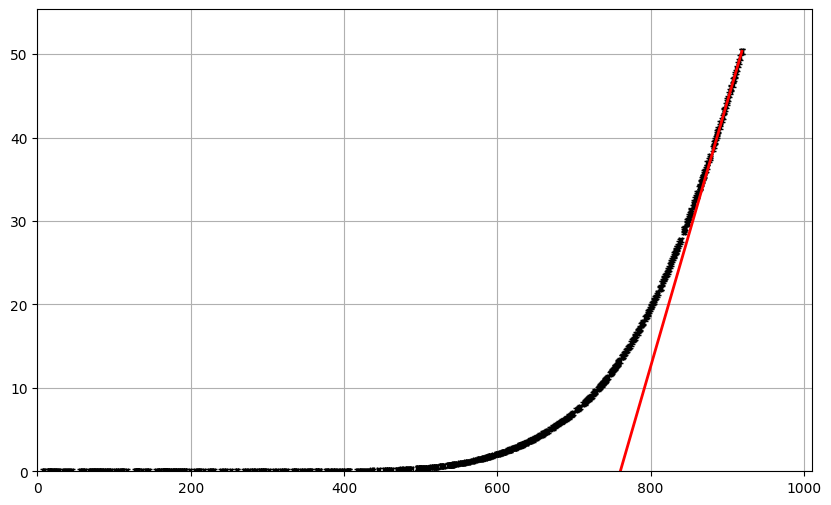

In [157]:
df = pd.read_csv(COVERED_DATA_PATH, sep=";")
df = compute_uncertainties(df)

U_sample, I_sample = df["U"][-10:], df["I"][-10:]
model = sm.OLS(I_sample, sm.add_constant(U_sample)).fit()

X_pred = np.linspace(0, U_sample.max(), 10)
X_pred2 = sm.add_constant(X_pred)
y_pred = model.predict(X_pred2)


fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(0, 1.1 * U_sample.max())
ax.set_ylim(0, 1.1 * I_sample.max())

ax.errorbar(
    df["U"],
    df["I"],
    xerr=df["u(U)"],
    yerr=df["u(I)"],
    color="black",
    fmt=".",
    capsize=2,
    markersize=0,
)
plt.plot(X_pred, y_pred, "r-", linewidth=2)
ax.grid()
plt.show()

## Logarithmic scale

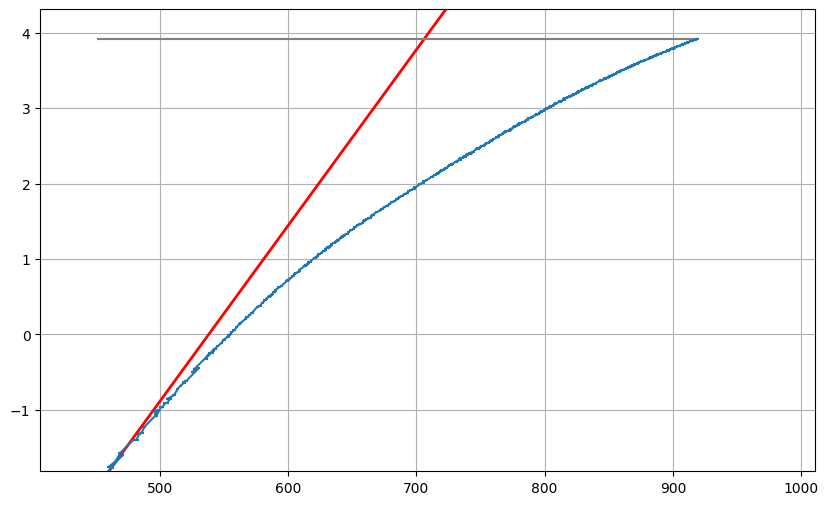

In [158]:
def predicate(row):
    return row["U"] > 450


df = pd.read_csv(COVERED_DATA_PATH, sep=";")
df = df.loc[df.apply(predicate, axis=1)]
df = compute_uncertainties(df)


U_sample, I_sample = df["U"][0:10], df["ln(I)"][0:10]
model = sm.OLS(I_sample, sm.add_constant(U_sample)).fit()

X_pred = np.linspace(0, df["U"].max(), 20)
X_pred2 = sm.add_constant(X_pred)
y_pred = model.predict(X_pred2)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(0.9 * df["U"].min(), 1.1 * df["U"].max())
ax.set_ylim(0.9 * df["ln(I)"].min(), 1.1 * df["ln(I)"].max())

ax.errorbar(df["U"], df["ln(I)"], xerr=df["u(U)"])
plt.plot(X_pred, y_pred, "r-", linewidth=2)

x_seq = np.linspace(df["U"].min(), df["U"].max(), 100)
y_seq = np.zeros_like(x_seq) + df["ln(I)"].max()
plt.plot(x_seq, y_seq, color="gray")

ax.grid()
plt.show()

# Illuminated photodiode

[-0.0591199994087219, -0.201570004224777, -0.348419994115829, -0.484100013971329, -0.58950001001358, -0.745299994945526] [417.0, 394.0, 372.0, 353.0, 338.0, 310.0] 417.0


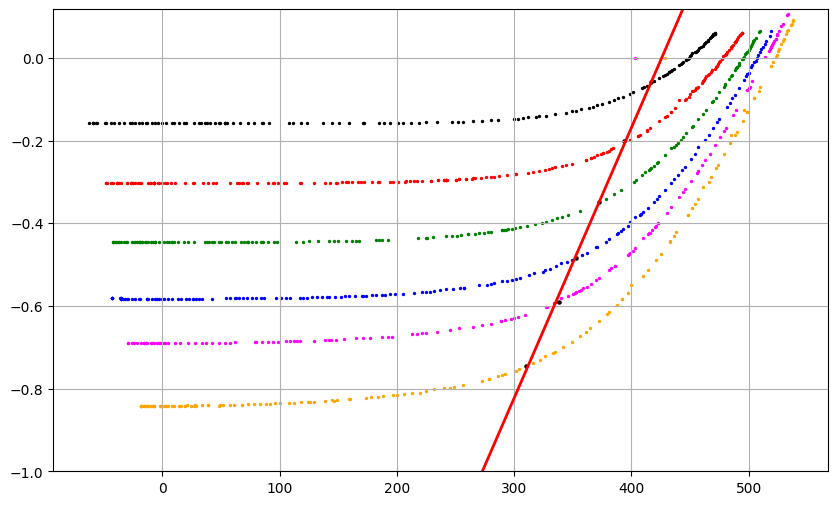

In [202]:
import random

dataframes = [
    pd.read_csv(path, delimiter=";")
    for path in [
        "data/7mA.csv",
        "data/13mA.csv",
        "data/19mA.csv",
        "data/25mA.csv",
        "data/31mA.csv",
        "data/38mA.csv",
    ]
]

shorting_currents = [df["I"][0:10].min() + 0.1 for df in dataframes]

shorted_currents = [
    df.iloc[(df["I"] - current).abs().idxmin()]
    for current, df in zip(shorting_currents, dataframes)
]

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_ylim(-1, 1.1 * max([df["I"].max() for df in dataframes]))

for df, color in zip(
    dataframes, ["black", "red", "green", "blue", "magenta", "orange"]
):
    plt.scatter(df["U"], df["I"], color=color, s=2)

for shorted_current in shorted_currents:
    plt.scatter(shorted_current["U"], shorted_current["I"], color="black", s=5)


# print(shorted_currents_df["I"])
currents = [df["I"] for df in shorted_currents]
voltates = [df["U"] for df in shorted_currents]
model = sm.OLS(currents, sm.add_constant(voltates)).fit()
X_pred = np.linspace(0, max(voltates) + 100, 10)
X_pred2 = sm.add_constant(X_pred)
y_pred = model.predict(X_pred2)

plt.plot(X_pred, y_pred, "r-", linewidth=2)

plt.grid()